In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid

#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, accuracy_score


In [56]:
train = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')


In [57]:
train = pd.concat([train, train2], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


### Encode Categories

In [58]:
binary_cols = ['Laptop Compartment', 'Waterproof']

mapping = {'Yes': 1, 'No': 0}

train[binary_cols] = train[binary_cols].map(mapping.get)
test[binary_cols] = test[binary_cols].map(mapping.get)

### Feature Imputation

In [59]:
num_cols = test.select_dtypes(include=['number']).columns

In [60]:
cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color',  'Laptop Compartment', 'Waterproof']

for col in cat_cols: 
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    impute_val = train[col].mode()
    train.fillna({col:impute_val}, inplace=True)
    test.fillna({col:impute_val}, inplace=True)


In [61]:
train.fillna({'Weight Capacity (kg)':train['Weight Capacity (kg)'].mean()}, inplace=True)
test.fillna({'Weight Capacity (kg)':test['Weight Capacity (kg)'].mean()}, inplace=True)

### Feature Engineering 

In [62]:
def engineer_features(df):

    df['weight_capacity_rounded'] = df['Weight Capacity (kg)'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['brand_material'] = df['Brand'].astype(str) + '_' + df['Material'].astype(str)
    df['brand_material'] = df['brand_material'].astype('category')

    df['brand_size'] = df['Brand'].astype(str) + '_' + df['Size'].astype(str)
    df['brand_size'] = df['brand_size'].astype('category')

    df['style_size'] = df['Style'].astype(str) + '_' + df['Size'].astype(str)
    df['style_size'] = df['style_size'].astype('category')

    df['style_material'] = df['Style'].astype(str) + '_' + df['Material'].astype(str)
    df['style_material'] = df['style_material'].astype('category')

    df['color_material'] = df['Color'].astype(str) + '_' + df['Material'].astype(str)
    df['color_material'] = df['color_material'].astype('category')

    df['weight_capacity_ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    df['weight_to_compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)

    df['compartments_bins'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category')

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.rename(columns={'weight capacity (kg)':'weight_capacity'})

    return df 

train = engineer_features(train.copy())
test = engineer_features(test.copy())



In [63]:
# get all cat cols and encode them 
cat_cols = [col for col in train.columns if train[col].dtype == 'category']

In [64]:
for col in cat_cols:
    enc = TargetEncoder(smoothing=50)
    train[col + '_te'] = enc.fit_transform(train[[col]], train['price'])  
    test[col + '_te'] = enc.transform(test[[col]])


### Scaling

In [67]:
num_cols = [col for col in train.columns if train[col].dtype != 'category']
num_cols.remove('price')
num_cols.remove('id')

In [68]:
scaler = StandardScaler()

train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

### Model

In [84]:
est_cols = [col for col in train.columns]
num_cols = [col for col in train.columns if train[col].dtype != 'category']

num_cols.remove('id')
num_cols.remove('price')
est_cols.remove('id')
est_cols.remove('price')

In [74]:
X = train[est_cols]
y = train['price']

In [75]:
xgb_params = {
    'n_estimators': [ 10, 20, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,4,5]
}

lgb_params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.1],
    'num_leaves': [40]
}

cb_params = {
    'iterations': [700],
    'learning_rate': [0.1],
    'depth': [4]
}

# Initialize the models
lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression', metric='rmse')
cb_model = cb.CatBoostRegressor(verbose=0, random_state=42, loss_function='RMSE')
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)


# Grid search setups
def run_grid_search(model, params, name, scoring='neg_root_mean_squared_error', X=X, y=y):
    grid = GridSearchCV(model, params, cv=3, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {-grid.best_score_}")
    return grid.best_estimator_


In [76]:
print("Running GridSearch for LightGBM...")
best_lgb = run_grid_search(lgb_model, lgb_params, "LightGBM")

Running GridSearch for LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 2662878, number of used features: 32
[LightGBM] [Info] Number of data points in the train set: 2662878, number of used features: 32
[LightGBM] [Info] Start training from score 81.348670
[LightGBM] [Info] Start training from sco

In [87]:
X = train[num_cols]
y = train['price']
best_cb = run_grid_search(cb_model, cb_params, "CatBoost", X=X, y=y)


Best parameters for CatBoost: {'depth': 4, 'iterations': 700, 'learning_rate': 0.1}
Best score for CatBoost: 38.8770487085923


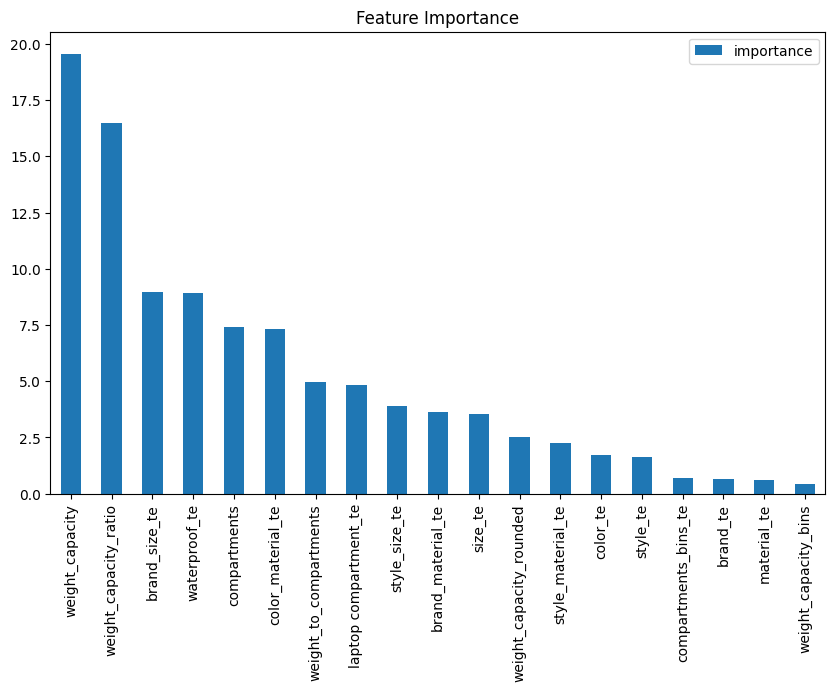

In [88]:
# plot feature importance of cat boost regressor

feature_importances = pd.DataFrame(best_cb.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

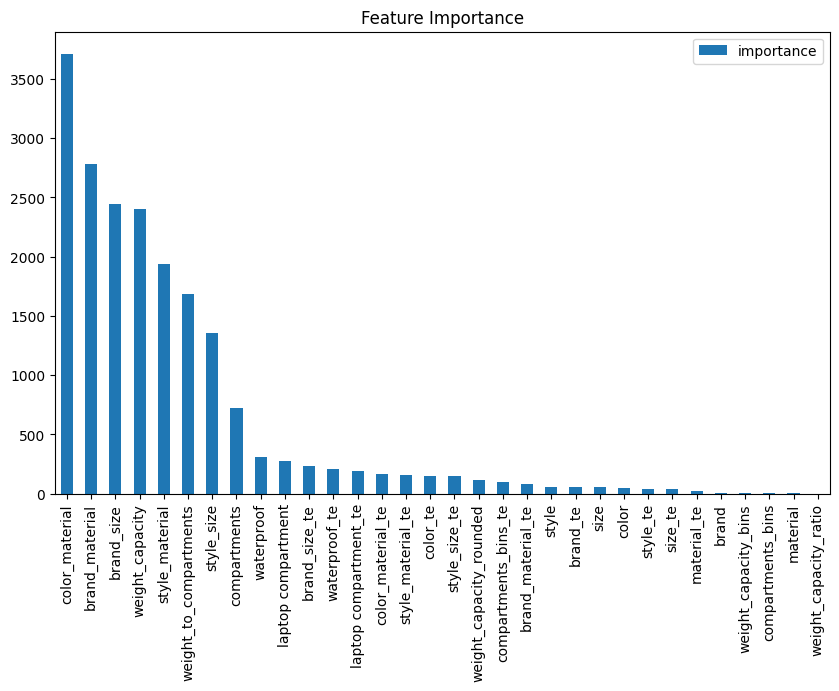

In [77]:
# plot feature importance of cat boost regressor

feature_importances = pd.DataFrame(best_lgb.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

In [82]:
final_features = feature_importances.head(8).index

In [89]:
X = train[final_features]
y = train['price']

best_lgb = run_grid_search(lgb_model, lgb_params, "LightGBM", X=X, y=y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 2662878, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 2662879, number of used features: 8
[LightGBM] [Info] Number of data po

: 

In [ ]:
def create_submission_file(sub_df):
    submission = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
    display(submission.head(2))
    file_name = datetime.now().strftime('submission_%Y%m%d_%H%M.csv')
    submission.to_csv(file_name, index = False)

### Feature Engineering

In [ ]:
def engineer_features(df, is_train_set=False):

    # first create price bins
    if is_train_set:
        df['round_price'] = df.Price.astype(int)
        binner = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
        binned_values = binner.fit_transform(df[['round_price']]).astype(int).flatten()

        # Create bin category column
        bin_col_name = f"price_cat"
        df[bin_col_name] = binned_values

    df['weight_capacity_rounded'] = df['Weight Capacity (kg)'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['brand_material'] = df['Brand'] + '_' + df['Material']
    df['brand_material'] = df['brand_material'].astype('category').cat.codes

    df['brand_size'] = df['Brand'] + '_' + df['Size']
    df['brand_size'] = df['brand_size'].astype('category').cat.codes

    df['style_size'] = df['Style'] + '_' + df['Size']
    df['style_size'] = df['style_size'].astype('category').cat.codes

    df['style_material'] = df['Style'] + '_' + df['Material']
    df['style_material'] = df['style_material'].astype('category').cat.codes

    df['color_material'] = df['Color'] + '_' + df['Material']
    df['color_material'] = df['color_material'].astype('category').cat.codes

    df['weight_capacity_ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    df['weight_to_compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)

    df['compartments_bins'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category').cat.codes

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.drop(columns=['brand', 'material', 'size', 'style', 'color'])

    df = df.rename({'weight capacity (kg)':'weight_capacity'})

    return df 

train = engineer_features(train.copy(), True)
test = engineer_features(test.copy())

